In [7]:
%matplotlib inline
from leicaexperiment import Experiment
from skimage import filters, morphology

%run utils.ipynb

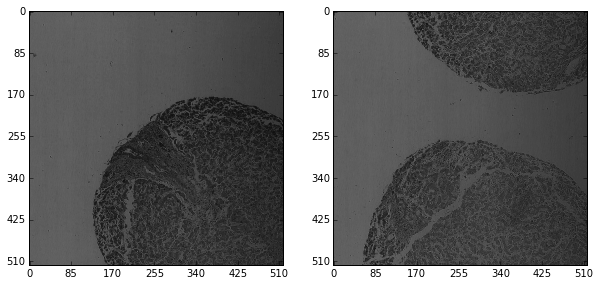

In [4]:
#path = r'D:\MatrixScreenerImages\3.3.0_9757'
#path += '\\'
path = "data/"
e = Experiment(path + 'experiment--2015_04_29_16_35_42')
p1 = e.images[0]
p2 = e.images[1]
side_by_side(p1, p2)

In [5]:
old_path = e.path
new_path = e.path + "_copy"

In [ ]:
!if [ -x $new_path ]; then rm -r $new_path; fi
!cp -r $old_path $new_path

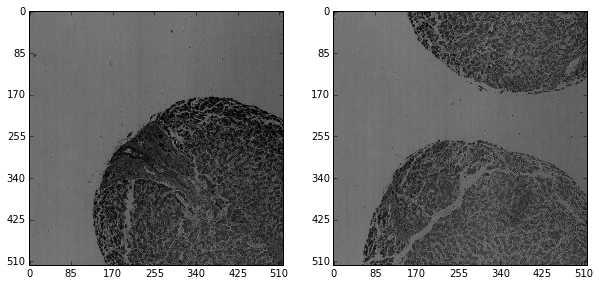

In [6]:
e = Experiment(new_path)
p1 = e.images[0]
p2 = e.images[1]
side_by_side(p1, p2)

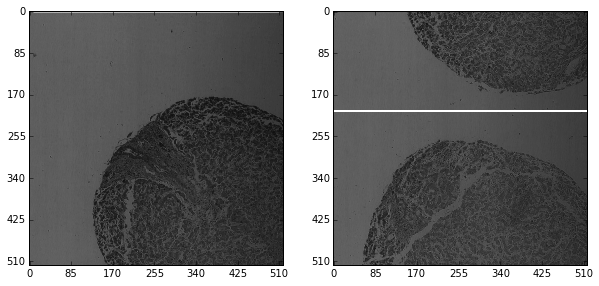

In [5]:
img1 = imread(p1)
line_variance = np.std(img1, axis=1)
min_line = np.argmin(line_variance)
img1[min_line-2:min_line+2, :] = 255

img2 = imread(p2)
line_variance = np.std(img2, axis=1)
min_line = np.argmin(line_variance)
img2[min_line-2:min_line+2, :] = 255


side_by_side(img1, img2)

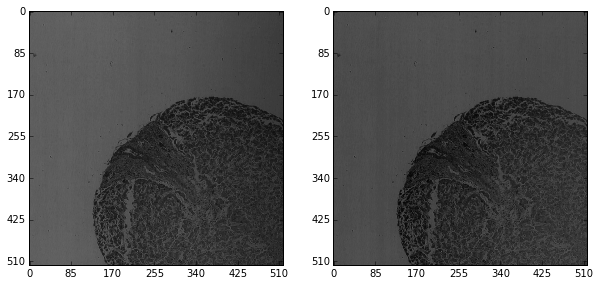

In [6]:
img1 = imread(p1)
selem = morphology.square(10)
smooth = filters.rank.median(img1, selem)

line_variance = np.std(img1, axis=1)
min_line = np.argmin(line_variance)

equalized1 = np.copy(img1.astype(np.int))
equalized1 -= smooth[min_line,:]
equalized1 -= equalized1.min()
side_by_side(img1, equalized1.astype(np.uint8))

right bottom of equalized has low contrast

In [7]:
def plot_intensities(*imgs):
    if len(imgs) > 1:
        figure(figsize=(len(imgs)*4,3))
    for n, img in enumerate(imgs):
        if type(img) == str:
            img = imread(img)
        subplot(1,len(imgs),n+1)
        for line in img:
            plot(line, 'b.')
        xlim(0, img.shape[1])

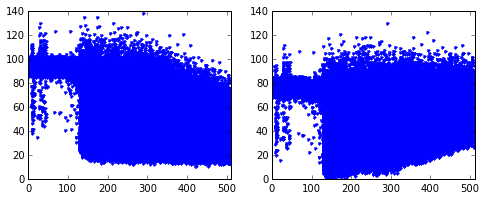

In [8]:
plot_intensities(img1, equalized1)

we need to compensate range of intensities for high x values

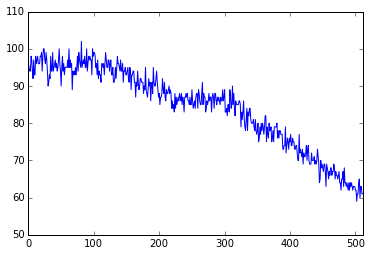

In [9]:
img1 = imread(p1)
line_variance = np.std(img1, axis=1)
line_number = np.argmin(line_variance)
intensity_profile = img1[line_number,:]
plot(intensity_profile)
xlim(0,512);

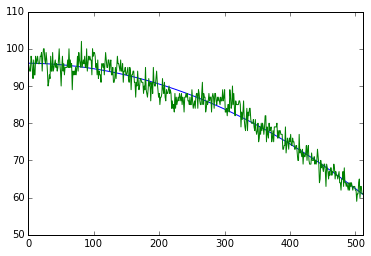

In [10]:
# use curve fit to avoid noise
from scipy.optimize import curve_fit

def line(x,a,b,c):
    return a*x**2+b*x+c

x = np.arange(512)
options, covariance = curve_fit(line, x, intensity_profile)
a,b,c = options

y = a*x**2+b*x+c
plot(y)
plot(intensity_profile)
xlim(0,512);

In [11]:
def get_intensity_profile(filename, axis=1):
    "Find smoothest line in image. Returns curve fit of the smooth line."
    img = imread(filename)

    line_variance = np.std(img, axis=axis)
    line_number = np.argmin(line_variance)

    def line(x,a,b,c):
        return a*x**2+b*x+c

    x = np.arange(img.shape[axis])
    coefficients, covariance = curve_fit(line, x, img[line_number,:])
    a,b,c = coefficients

    y = a*x**2+b*x+c
    # normalize
    return y/y.max()

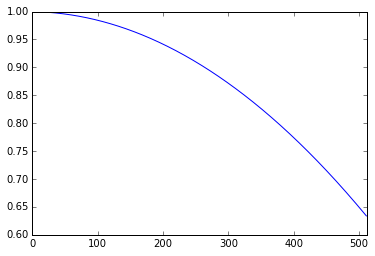

In [12]:
intensity_profile = get_intensity_profile(e.image(0,0,0,0))
plot(intensity_profile)
xlim(0,512);

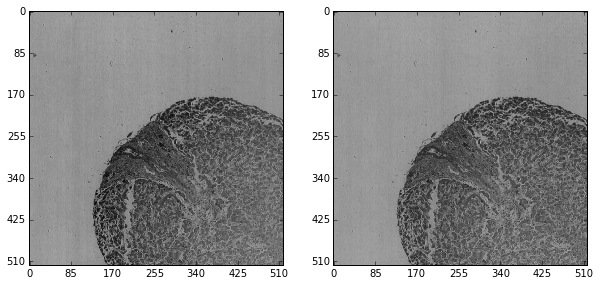

In [13]:
equalized2 = np.copy(img1.astype(np.float))

# equalize
equalized2 /= intensity_profile

# ensure we are not above 1
equalized2 /= equalized2.max()

side_by_side(equalized1/equalized1.max(), equalized2)

contrast seem better, lets compare the range of intensities

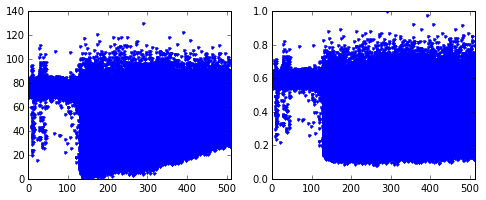

In [14]:
plot_intensities(equalized1, equalized2)

use whole range

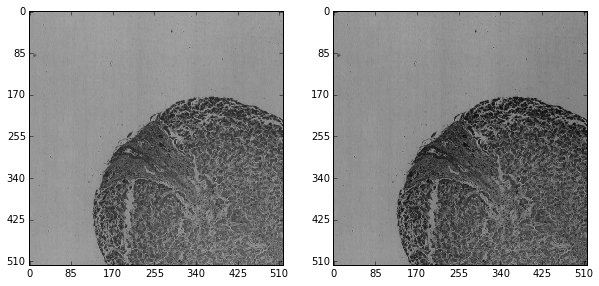

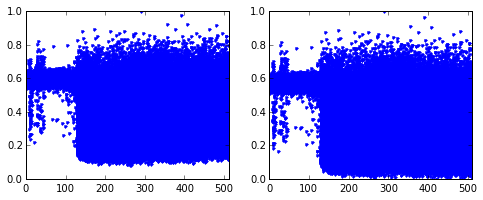

In [15]:
equalized3 = np.copy(img1.astype(np.float))

# exploit whole intensity range
equalized3 -= equalized3.min()
equalized3 /= equalized3.max()

# equalize
equalized3 /= intensity_profile

# ensure we are not above 1
equalized3 /= equalized3.max()

side_by_side(equalized2, equalized3)
plot_intensities(equalized2, equalized3)

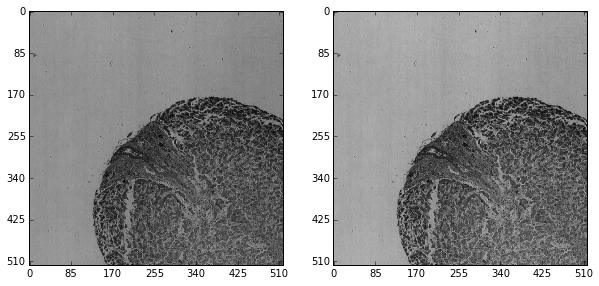

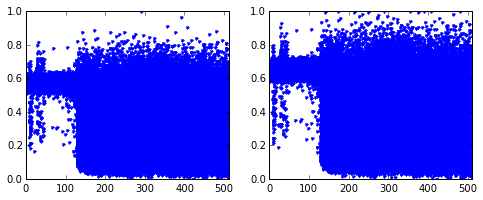

In [16]:
equalized4 = np.copy(img1.astype(np.float))

# exploit whole intensity range
equalized4 -= equalized4.min()
equalized4 /= equalized4.max()

# equalize
equalized4 /= intensity_profile

# clip values above 1
equalized4[equalized4 > 1] = 1

side_by_side(equalized3, equalized4)
plot_intensities(equalized3, equalized4)

In [17]:
img1.max(), img1.min()

(139, 11)

In [18]:
from joblib import Parallel, delayed

def min_max(filename):
    img = imread(filename)
    return img.min(), img.max()

mm = Parallel(n_jobs=4)(delayed(min_max)(f) for f in e.images)
mm = np.array(mm)

In [19]:
mins = mm[:,0]
mins.min(), mins.max(), mins.mean(), np.median(mins)

(11, 27, 18.733333333333334, 19.0)

In [20]:
maxs = mm[:,1]
maxs.min(), maxs.max(), maxs.mean(), np.median(maxs)

(128, 255, 190.39393939393941, 191.0)

In [21]:
from skimage import img_as_ubyte

def remove_intensity_variation(filename, intensity_profile, intensity_range=None):
    """Equalizes rows in image according to intensity profile.
    
    Parameters
    ----------
    filename : string
        Image to equalize.
    intensity_profile : array
        Normalized profile of intensity.
    intensity_range : (min,max) int
        Normalize to this range before equalizing.
    """

    img = imread(filename).astype(np.float)
    
    if not intensity_range:
        intensity_range = img.min(), img.max()
    
    # normalize
    img -= intensity_range[0]
    img /= intensity_range[1] - intensity_range[0]
    
    # equalize
    img /= intensity_profile

    # clip values
    img[img < 0] = 0
    img[img > 1] = 1

    imsave(filename, img_as_ubyte(img))

/Users/arve/.virtualenvs/3.4/lib/python3.4/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


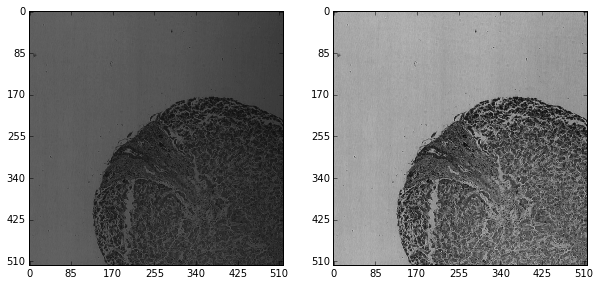

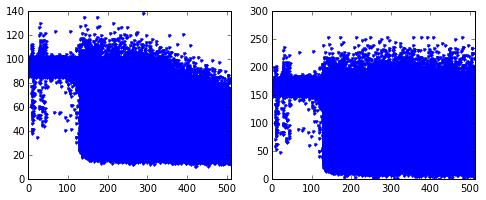

In [22]:
!cp $p1 temp.png
remove_intensity_variation('temp.png', intensity_profile)
side_by_side(p1, 'temp.png')
plot_intensities(p1, 'temp.png')

In [28]:
%%time
intensity_range = np.median(mins), np.median(maxs)
Parallel(n_jobs=4)(
    delayed(remove_intensity_variation)
      (f, intensity_profile, intensity_range) for f in e.images);

CPU times: user 182 ms, sys: 48.1 ms, total: 230 ms
Wall time: 6.86 s


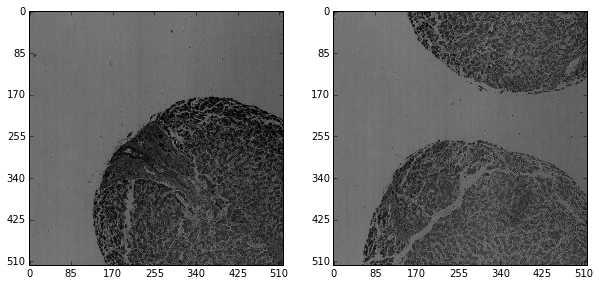

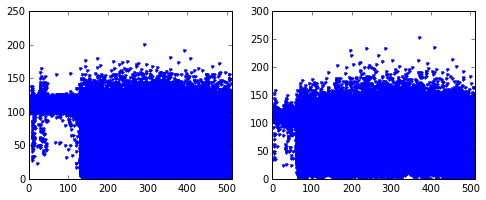

In [31]:
side_by_side(p1, p2)
plot_intensities(p1, p2)

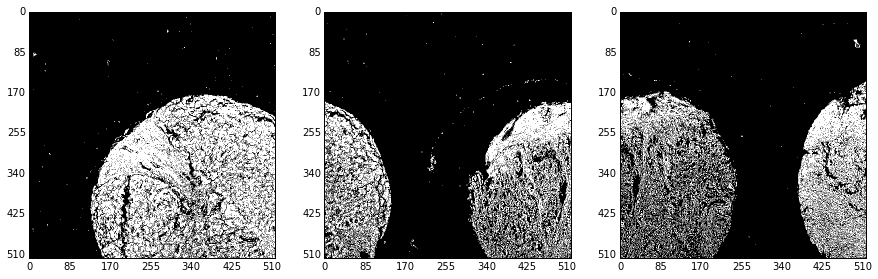

In [9]:
img1 = imread(e.image(0,0,0,0))
img2 = imread(e.image(0,0,0,1))
img3 = imread(e.image(0,0,0,2))
thresh = filters.threshold_otsu(img1)
side_by_side(img1 < thresh, img2 < thresh, img3 < thresh)

In [ ]:
from microscopestitching import stitch
from leicaexperiment import attributes

images = []
for img in e.images:
    attr = attributes(img)
    images.append((img, attr.y, attr.x))

merged = stitch(images)

In [16]:
imsave('merged.png', merged)

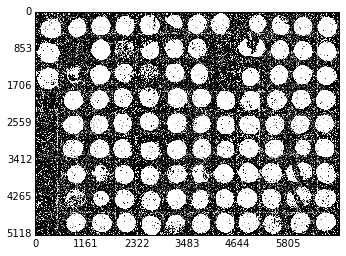

In [18]:
selem = morphology.square(3)
ent = filters.rank.entropy(merged, selem)
thresh = filters.threshold_li(ent)
mask = ent >= thresh
imshow_downscale(mask)